In [1]:
%matplotlib inline
"""
Monte Carlo simulation of the 2D Ising model
"""

from scipy import *
# from scipy import weave
from pylab import *
import random
import numpy as np
import numba as nb

Nitt = int(5e5)  # total number of Monte Carlo steps
N = 40          # linear dimension of the lattice, lattice-size= N x N
warm = int(1e5)     # Number of warmup steps
measure=100     # How often to take a measurement

@nb.jit(nopython=True)
def CEnergy(latt):
    "Energy of a 2D Ising lattice at particular configuration"
    Ene = 0
    for i in range(len(latt)):
        for j in range(len(latt)):
            S = latt[i,j]
            WF = latt[(i+1)%N, j] + latt[i,(j+1)%N] + latt[(i-1)%N,j] + latt[i,(j-1)%N]
            Ene += -WF*S # Each neighbor gives energy 1.0
    return Ene/2. # Each par counted twice

@nb.jit(nopython=True)
def RandomL(N):
    "Radom lattice, corresponding to infinite temerature"
#     latt = np.zeros((N,N), dtype=int)
    latt = np.zeros((N,N))
  
    for i in range(N):
        for j in range(N):
            latt[i,j] = sign(2*rand()-1)
    return latt

@nb.jit(nopython=True)
def SamplePython(Nitt, latt, PW):
    "Monte Carlo sampling for the Ising model in Pythons"
    Ene = CEnergy(latt)  # Starting energy
    Mn=sum(latt)         # Starting magnetization
#     print(latt[0])
    Naver=0       # Measurements
    Eaver=0.0
    Maver=0.0
    
    N2 = N*N
    
    Ene_all = np.arange(0,Nitt)
    Mn_all = np.arange(0,Nitt)
    for itt in range(Nitt):
        t = int(rand()*N2)  # choose one of N2 sites to flip
        (i,j) = (t % N, int(t/N) )
        S = latt[i,j]
        WF = latt[(i+1)%N, j] + latt[i,(j+1)%N] + latt[(i-1)%N,j] + latt[i,(j-1)%N]
        P = PW[int(4+S*WF)]
        if P>rand(): # flip the spin
            latt[i,j] = -S
            Ene += 2*S*WF
            Mn -= 2*S
        
        Ene_all[itt] = Ene
        Mn_all[itt] = Mn
        
        if itt>warm and itt%measure==0:
            Naver += 1
            Eaver += Ene
            Maver += Mn
    
#     plt.plot(range(0,Nitt), Ene_all, range(0,Nitt), Mn_all)
#     plt.xlabel('step')
#     plt.ylabel('energy')
#     plt.show()
    
    return (Maver/Naver/N2, Eaver/Naver/N2)   

@nb.jit(nopython=True)
def main():
    
#     PW = np.zeros(9, dtype=float)
    PW = np.zeros(9)

    wT = linspace(2.5,2.0,4)
#     wT = [2.25]
    wMag=np.zeros(len(wT))
    wEne=np.zeros(len(wT))
    wCv=np.zeros(len(wT))
    wChi=np.zeros(len(wT))
    for i in range(len(wT)):
#     for T in wT:
        latt = RandomL(N)
        T=wT[i]
        print("T= ", T)
        
        # Precomputed exponents
        PW[4+4] = exp(-4.*2/T)
        PW[4+2] = exp(-2.*2/T)
        PW[4+0] = exp(0.*2/T)
        PW[4-2] = exp( 2.*2/T)
        PW[4-4] = exp( 4.*2/T)
        
#         print(latt[0])
    
        (maver, eaver) = SamplePython(Nitt, latt, PW)
        wMag[i] = maver
        wEne[i] = eaver
#         wMag.append(maver)
#         wEne.append(eaver)
#         (aM, aE, cv, chi) = SampleCPP(Nitt, latt, PW, T)
#         wMag.append( aM/(N*N) )
#         wEne.append( aE/(N*N) )
#         wCv.append( cv/(N*N) )
#         wChi.append( chi/(N*N) )
        
#         print(T, aM/(N*N), aE/(N*N), cv/(N*N), chi/(N*N) )
        
#     plot(wT, wEne, label='E(T)')
#     plot(wT, wCv, label='cv(T)')
#     plot(wT, wMag, label='M(T)')
#     xlabel('T')
#     legend(loc='best')
#     show()
#     plot(wT, wChi, label='chi(T)')
#     xlabel('T')
#     legend(loc='best')
#     show()
    return wT, wMag, wEne

T=  2.5
T=  2.3333333333333335
T=  2.1666666666666665
T=  2.0


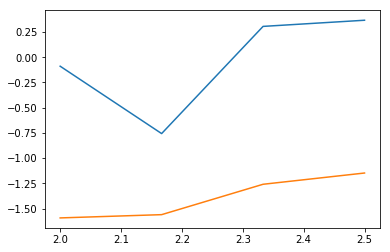

In [2]:
wT, wMag, wEne = main()
plt.plot(wT, wMag, wT, wEne)